# <center>**Classification of Unraveled Spirals**<center>

#### **Goal:** obtain a distance error between the misclassified hand drawn spirals and a LOBF ("ideal") spiral

Any functions / processes that require the use of tensorflow or keras need to be in this file. Other functions can be in a seperate python file. 

## **Process**
1. Import the skeletonized images
    - Convert to grayscale
    - Save all images in an array with the corresponding labels
2. Unravel all of the spirals
    - Normalize so they all have the same length
        - Do this by zero-padding?
3. Perform spline fitting
    - Subtract the spline from hand-drawing
    - This is the "deviation signal"
    - Convert to the frequency domain
        - Take the fft
        - Plot the magnitude of a couple of the spirals
5. Extract features
    - Need to decide what will be passed in as features for classification
        - variance, SNR, bandwidth, peaks, center freq?
6.  Run features through classifiers
    - RF, SVM, NB, KNN


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import warnings
import seaborn as sns

# import ML libraries
from sklearn import utils, svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.interpolate import UnivariateSpline 
from scipy import interp

# import files with certain functions
from code_files.archSpiral import * # functions of interest are 'unravelSpiral' and 'calcDist_to_center' 

warnings.filterwarnings('ignore')

c:\Users\Rebecca\anaconda3\envs\MLEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## <center>Step 1: Import Skeletonized Images<center>

size of imgs array:  (352, 1000, 1000)
size of lbls array:  (352,)
Healthy:  176 , PD:  176


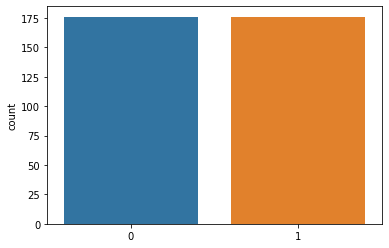

In [5]:
dir = os.getcwd()
folder_path = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/database-images/database-images/skel/spiral' #dir + '/datasets/folador_skeletonize/skeletons/spirals/'
run_balanced = True
imgs = [] # create empty array to store all the images
lbls = [] # create empty array to store the labels of the images
img_names = []
for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    
    # convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img[img > 50] = 255
    img[img != 255] = 0

    # save the labels in 'lbls' array
    # need to determine if it is healthy or parkinsons based on 'H' or 'P' being present in the file name
    if 'H' in img_name:
        if run_balanced:
            if len(lbls)-np.count_nonzero(lbls) < 176:
                lbls.append(0)
                # save image in 'imgs' array
                imgs.append(img)
        else:
            lbls.append(0)
            # save image in 'imgs' array
            imgs.append(img)

    else:
        lbls.append(1)
        # save image in 'imgs' array
        imgs.append(img)

    img_names.append(img_name)

# shuffle the data
# imgs, lbls = utils.shuffle(imgs, lbls)

print("size of imgs array: ", np.shape(imgs))
print("size of lbls array: ", np.shape(lbls))

# plot the distribution of labls
sns.countplot(lbls)
print("Healthy: ", len(lbls)-np.count_nonzero(lbls), ", PD: ", np.count_nonzero(lbls))

## <center>Step 2: Unravel Spirals<center>

In [6]:
numImgs = len(imgs)
unraveledSpirals = [] # create empty array to store unraveled spirals

# iterate through all images and unravel
for i in range(numImgs):
    print(i, end='\r')
    center = unravelSpiral(imgs[i])
    unravelledImg = calcDist_to_center(imgs[i], center)
    unraveledSpirals.append(unravelledImg)

print(np.shape(unraveledSpirals))

# then need to normalize (do by zero padding)

(352,)


## <center>Step 3: Perform Spline Fitting<center>

In [7]:
fftSignals = [] 

# iterate through all the unravelled spirals
# fit a spline to each spiral individually
# subtract the spline from the hand-drawing
# store this difference signal in 'deviationSignals'
for i in range(numImgs):
    print(i+1, end='\r')
    # print(img_names[i])

    hand_drawing = unraveledSpirals[i][::2]
    numSamples = np.linspace(0, len(hand_drawing)-1, len(hand_drawing))    

    pad_width = 3750 - len(hand_drawing)
    pad_array = np.ones(pad_width).astype(np.int) 


    # calculate the line-of-best-fit (LOBF) or "spline"
    spl = UnivariateSpline(numSamples, hand_drawing, s=len(numSamples)*25, k=2)
    lobf = spl(numSamples)

    # plt.plot(hand_drawing)
    # plt.plot(lobf)
    # plt.show()

    # take the difference
    diff = hand_drawing - lobf
    diff = np.append(diff, (pad_array * 0))
    
    # take the magnitude of the fft to convert to the frequency domain
    diff = (np.abs(np.fft.fftshift(np.fft.fft(diff)) / 3750))
    mean = np.mean(diff)
    # diff = np.append(diff, (pad_array * mean))

    fftSignals.append(diff)
    
    xaxis = np.linspace(0, 3750-1, 3750)
    yaxis = np.append(hand_drawing, pad_array)
    lobf = np.append(lobf, pad_array)

    # fig, ax = plt.subplots(1,2,figsize=(20,5))
    # ax[0].plot(xaxis, yaxis, label="data", color='r')
    # ax[0].plot(xaxis, lobf, label="LOBF", color='b')
    # ax[1].plot(xaxis, diff)
    # plt.show()

## <center>Step 4: Extract Features<center>

In [8]:
# SNR, variance, BW, center freq, peaks

# obtain the magnitude
peaks = []
centers = []
var = []
snr = []
bw = []

for i in range(numImgs):
    sig = np.around(fftSignals[i], decimals=10) # round the values to 10 decimal places
    max = np.max(sig) # calculate the peak

    # find the "center freq" location
    peak_loc = np.argwhere(sig == max) 
    # center_loc = peak_loc[0] + int((peak_loc[1] - peak_loc[0])/2)
    center_loc = int(peak_loc[1])

    # calculate the variance
    sigVar = np.var(sig)

    # calculate SNR
    # seperate into noise part and signal part
    # calculate noise_floor threshold
    noise_floor = np.mean(sig)*2
    nf_approx = np.around(noise_floor,3)
    part_sig=[]
    part_noise=[]
    for samp in sig:
        if samp > nf_approx:
            part_sig.append(samp)
        else:
            part_noise.append(samp)
    # calc SNR
    m_sq = np.mean(part_sig)**2
    v    = np.var(part_noise)
    sigSNR = m_sq / v # mean of the signal squared / variance of the noise

    # avg = np.mean(sig)
    # std_dev = np.std(sig)
    # sigSNR = np.where(std_dev == 0, 0, avg/std_dev)

    # calculate the bandwidth
    # this will just be the total number of signal samples
    sigBW = len(part_sig)

    peaks.append(max)
    centers.append(center_loc)
    var.append(sigVar)
    snr.append(sigSNR)
    bw.append(sigBW)

In [11]:
# plot the histogram infromation of an images
# need to load in the original images (do this based on 'image_names' and just need to remove 'skel_' from out front)
# will need to set the right folder paths to load the folders
hist = []
thresh_val=[]
orig_img_folder_path = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/database-images/database-images/orig/spiral/'
for i in range(numImgs):
    print(i, end='\r')
    img_name = img_names[i].replace('skel_', '')
    
    if 'H' in img_name:
        group = 'healthy/'
    else:
        group = 'parkinson/'

    path = orig_img_folder_path + group + img_name
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # create the histogram
    thresh = np.mean(img)
    error = 255 - thresh
    thresh = np.around(thresh - error, 1)

    sigHist = 0
    sigThresh = thresh
    for x in range(np.shape(img)[0]):
        for y in range(np.shape(img)[1]):
            if img[x][y] < thresh:
                sigHist+=1

    hist.append(sigHist)
    thresh_val.append(sigThresh)

## <center>Step 5: Run Features Through Classifier<center>

In [82]:
# first put all the features in a dataframe

# try classifying with SVM
# https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python 

In [12]:
fft_features = {'labels':lbls,'peaks': peaks, 'centers':centers, 'variance':var, 'SNR':snr, 'BW':bw, 'hist': hist, 'thresh_val': thresh_val}
fft_df = pd.DataFrame(fft_features)
fft_df = fft_df.reset_index(drop=True)
fft_df.head()

# save as csv 
# fft_df.to_csv('fft_df.csv', index=False)
# fft_raw = {'fft_data': fftSignals, 'labels':lbls}
# fft_raw = pd.DataFrame(fft_raw)
# fft_raw.head()


,labels,peaks,centers,variance,SNR,BW,hist,thresh_val
0,0,1.190806,1890,0.003942,1560.241379,214,4338,239.6
1,0,1.411753,1889,0.003797,953.259497,226,4412,238.7
2,0,1.360222,1888,0.003973,974.760757,228,4973,236.0
3,0,1.110209,1888,0.003928,919.422004,222,4598,235.8
4,0,1.060126,1894,0.004830,1096.733405,214,5060,235.4


In [149]:
x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels', 'hist', 'thresh_val'], axis=1), fft_df.labels, test_size=0.20, random_state=24) #'peaks', 'variance', 'SNR', stratify=fft_df.labels

<AxesSubplot:xlabel='labels', ylabel='count'>

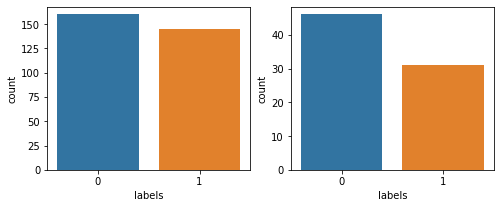

In [128]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
sns.countplot(y_train, ax=ax[0])
sns.countplot(y_test, ax=ax[1])

### SVM

In [65]:
clf = svm.SVC(kernel='poly')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5844155844155844


In [ ]:
# create SVM classifier
def SVM_classifier(train_data, train_labels, val_data, val_labels):
    cv_acc = []
    
    # convert labels to an array
    val_labels = np.array(val_labels)
    #clf = svm.SVC(kernel='poly', degree=5)
    param_grid={'C':[100],'degree':[7],'kernel':['poly']}
    clf = svm.SVC(probability=True)
    svm_clf = GridSearchCV(clf, param_grid, cv=5)

    # train model
    svm_clf.fit(train_data, train_labels)
    # print(model.cv_results_.keys())
    # print(svm_clf.cv_results_)

    svm_clf.best_params_
    # print(svm_clf.best_params_)

    # predict the model
    pred = (svm_clf.predict(val_data))

    # calculate accuracy
    acc = round(metrics.accuracy_score(val_labels, pred),4)
    cfm = metrics.confusion_matrix(val_labels, pred)
    tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
    tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

    # compute info for ROC curve
    y_score = svm_clf.predict_proba(val_data)
    xaxis, yaxis, _ = metrics.roc_curve(val_labels, y_score[:,1], pos_label=1, drop_intermediate=False)

    # print("The predicted data is: ", pred)
    # print("The actual data is: ", np.array(val_labels))
    # print(f"The model is {acc*100}% accurate")

    return acc, tpr, tnr, cfm, xaxis, yaxis

svm_acc = []
svm_tpr = []
svm_tnr = []
svm_cfm = []
svm_xaxis = []
svm_yaxis = []

for ii in range(1):
    print('Random State: ', ii+1, end='\r')
    rs = np.linspace(1, 50, 50).astype(np.int)
    x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels', 'hist', 'thresh_val'], axis=1), fft_df.labels, test_size=0.20, random_state=rs[42]) #'peaks', 'variance', 'SNR', stratify=fft_df.labels
    temp_acc, temp_tpr, temp_tnr, temp_cfm, temp_xaxis, temp_yaxis = SVM_classifier(x_train, y_train, x_test, y_test)
    # svm_acc.append(temp_acc)
    # svm_tpr.append(temp_tpr)
    # svm_tnr.append(temp_tnr)
    # svm_cfm.append(temp_cfm)

    # svm_xaxis.append(temp_xaxis)
    # svm_yaxis.append(temp_yaxis)


# print("Accuracy scores: ", svm_acc)
print("Average accuracy: ", np.mean(svm_acc))
print("Standard deviation: ", np.std(svm_acc))
print("Average TNR: ", np.mean(svm_tnr))
print("Average TPR: ", np.mean(svm_tpr))

In [23]:
# SVM with one set random state
def freq_feature_classification(data, labels, classifier):  
    rs = 42 # define the random state
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs) # this is approximately a 80-20 split

    if classifier == 'SVM':
        param_grid={'C':[100],'degree':[7],'kernel':['poly']}
        clf = svm.SVC(kernel='poly', C=100, degree=7, probability=True, random_state=rs)
        # clf = GridSearchCV(clf, param_grid)

    if classifier == 'RF':
        param_grid = {'n_estimators': [200], 'max_features': ['sqrt'], 'max_depth' : [10], 'criterion' :['gini'], 'random_state': [10]}
        clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=10, criterion='gini', random_state=rs)

    if classifier == 'NB':
        clf = GaussianNB()
        
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)

    acc = []
    cfm_storage = []
    tpr_storage = []
    tnr_storage = []
    prec = []
    recall = []
    f1 = []

    i=0
    plt.figure(figsize=(10,8))
    for train, test in cv.split(data, labels):
        # print("Train - # pd labels: ", (labels.iloc[train[:]]).value_counts()[1], '# h labels: ', (labels.iloc[train[:]]).value_counts()[0])
        # print("Test - # pd labels: ", (labels.iloc[test[:]]).value_counts()[1], '# h labels: ', (labels.iloc[test[:]]).value_counts()[0])
        probas_ = clf.fit(data.iloc[train[:]], labels.iloc[train[:]]).predict_proba(data.iloc[test[:]])
        # compute the ROC curve and area under the curve
        fpr, tpr, thresholds = metrics.roc_curve(labels.iloc[test[:]], probas_[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0]=0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)

        # predict the model
        pred = (clf.predict(data.iloc[test[:]]))

        # calculate accuracy
        acc.append(round(metrics.accuracy_score(labels.iloc[test[:]], pred),4))
        cfm = metrics.confusion_matrix(labels.iloc[test[:]], pred)
        clf_report = metrics.classification_report(labels.iloc[test[:]], pred, output_dict=True)
        cfm_storage.append(cfm)
        tpr_storage.append(cfm[0][0] / (cfm[0][0] + cfm[1][0]))
        tnr_storage.append(cfm[1][1] / (cfm[1][1] + cfm[0][1]))
        prec.append(clf_report['macro avg']['precision'])
        recall.append(clf_report['macro avg']['recall'])
        f1.append(clf_report['macro avg']['f1-score'])

        i+=1

    
    plt.plot([0,1],[0,1], linestyle='--', lw=2, color='k', label='Baseline', alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'font.family': 'Times New Roman'})
    plt.show()

    return acc, cfm, tpr_storage, tnr_storage, prec, recall, f1

In [19]:
x_train = fft_df.drop(['labels'], axis=1)
y_train = fft_df.labels

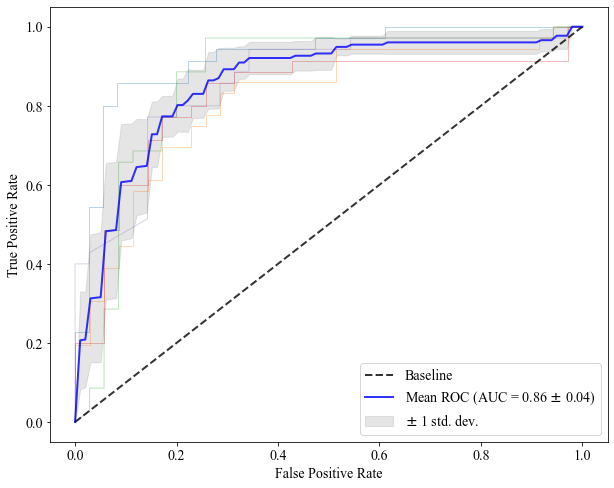

[0.8451, 0.7606, 0.8, 0.7571, 0.7714]
Accuracy - min: 0.7571, max: 0.8451, avg: 0.7868, std. dev: 0.0328
TPR - min: 0.6957, max: 0.7907, avg: 0.7454, std. dev: 0.0363
TNR - min: 0.8065, max: 0.9286, avg: 0.8512, std. dev: 0.0452
Precision - min: 0.7657, max: 0.8596, avg: 0.7983, std. dev: 0.0327
Recall - min: 0.7571, max: 0.8437, avg: 0.7867, std. dev: 0.0321
f1-score - min: 0.7510, max: 0.8431, avg: 0.7847, std. dev: 0.0335


In [25]:
svm_acc, svm_cfm, svm_tpr, svm_tnr, svm_prec, svm_recall, svm_f1 = freq_feature_classification(x_train, y_train, 'SVM')

print(svm_acc)
print('Accuracy - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_acc), np.max(svm_acc), np.mean(svm_acc), np.std(svm_acc)))
print('TPR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_tpr), np.max(svm_tpr), np.mean(svm_tpr), np.std(svm_tpr)))
print('TNR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_tnr), np.max(svm_tnr), np.mean(svm_tnr), np.std(svm_tnr)))
print('Precision - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_prec), np.max(svm_prec), np.mean(svm_prec), np.std(svm_prec)))
print('Recall - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_recall), np.max(svm_recall), np.mean(svm_recall), np.std(svm_recall)))
print('f1-score - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(svm_f1), np.max(svm_f1), np.mean(svm_f1), np.std(svm_f1)))

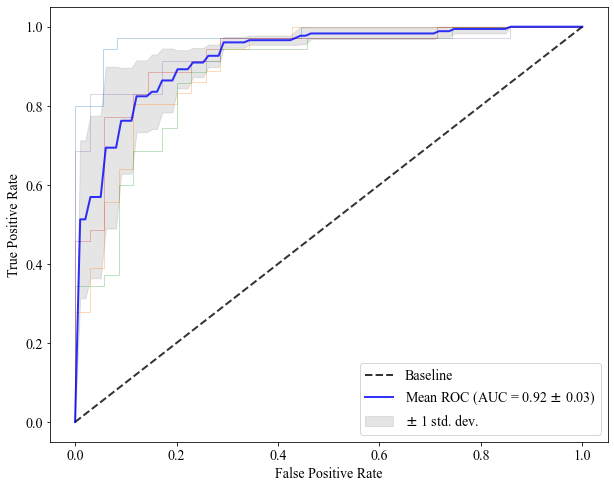

[0.9155, 0.8169, 0.8143, 0.8429, 0.8429]
Accuracy - min: 0.8143, max: 0.9155, avg: 0.8465, std. dev: 0.0366
TPR - min: 0.8000, max: 0.8947, avg: 0.8401, std. dev: 0.0362
TNR - min: 0.7750, max: 0.9394, avg: 0.8592, std. dev: 0.0569
Precision - min: 0.8171, max: 0.9171, avg: 0.8496, std. dev: 0.0360
Recall - min: 0.8143, max: 0.9151, avg: 0.8464, std. dev: 0.0364
f1-score - min: 0.8133, max: 0.9153, avg: 0.8461, std. dev: 0.0367


In [21]:
rf_acc, rf_cfm, rf_tpr, rf_tnr, rf_prec, rf_recall, rf_f1 = freq_feature_classification(x_train, y_train, 'RF')

print(rf_acc)
print('Accuracy - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_acc), np.max(rf_acc), np.mean(rf_acc), np.std(rf_acc)))
print('TPR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_tpr), np.max(rf_tpr), np.mean(rf_tpr), np.std(rf_tpr)))
print('TNR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_tnr), np.max(rf_tnr), np.mean(rf_tnr), np.std(rf_tnr)))
print('Precision - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_prec), np.max(rf_prec), np.mean(rf_prec), np.std(rf_prec)))
print('Recall - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_recall), np.max(rf_recall), np.mean(rf_recall), np.std(rf_recall)))
print('f1-score - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(rf_f1), np.max(rf_f1), np.mean(rf_f1), np.std(rf_f1)))

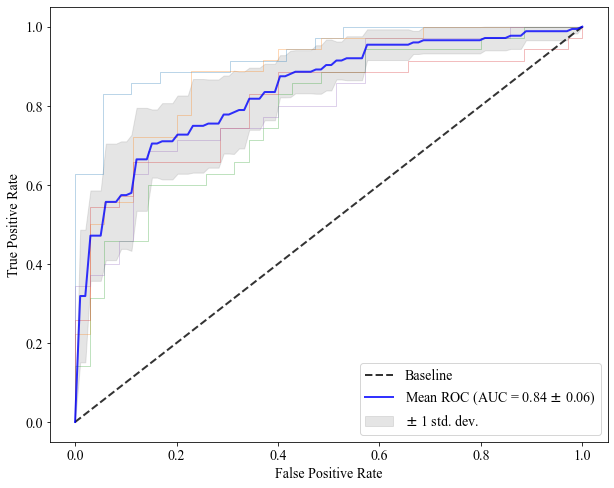

[0.8592, 0.7887, 0.7143, 0.7429, 0.7429]
Accuracy - min: 0.7143, max: 0.8592, avg: 0.7696, std. dev: 0.0507
TPR - min: 0.6735, max: 0.8421, avg: 0.7371, std. dev: 0.0648
TNR - min: 0.7742, max: 0.9048, avg: 0.8271, std. dev: 0.0542
Precision - min: 0.7261, max: 0.8604, avg: 0.7821, std. dev: 0.0462
Recall - min: 0.7143, max: 0.8587, avg: 0.7695, std. dev: 0.0506
f1-score - min: 0.7105, max: 0.8589, avg: 0.7665, std. dev: 0.0528


In [22]:
nb_acc, nb_cfm, nb_tpr, nb_tnr, nb_prec, nb_recall, nb_f1 = freq_feature_classification(x_train, y_train, 'NB')

print(nb_acc)
print('Accuracy - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_acc), np.max(nb_acc), np.mean(nb_acc), np.std(nb_acc)))
print('TPR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_tpr), np.max(nb_tpr), np.mean(nb_tpr), np.std(nb_tpr)))
print('TNR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_tnr), np.max(nb_tnr), np.mean(nb_tnr), np.std(nb_tnr)))
print('Precision - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_prec), np.max(nb_prec), np.mean(nb_prec), np.std(nb_prec)))
print('Recall - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_recall), np.max(nb_recall), np.mean(nb_recall), np.std(nb_recall)))
print('f1-score - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(nb_f1), np.max(nb_f1), np.mean(nb_f1), np.std(nb_f1)))

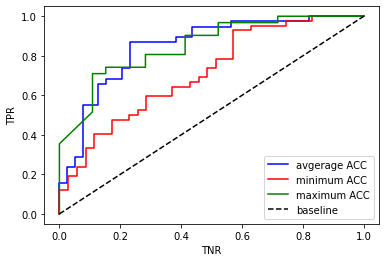

In [40]:
# plot the roc curve
# find the run that was closest to the average, the minimum average, and the maximum average
avg_loc = np.where(svm_acc == min(svm_acc, key=lambda x:abs(x-np.mean(svm_acc))))[0]
print(avg_loc)
avg_run = [svm_xaxis[avg_loc[0]], svm_yaxis[avg_loc[0]]]
min_loc = np.where(svm_acc == np.min(svm_acc))[0]
min_run = [svm_xaxis[min_loc[0]], svm_yaxis[min_loc[0]]]
max_loc = np.where(svm_acc == np.max(svm_acc))[0]
max_run = [svm_xaxis[max_loc[0]], svm_yaxis[max_loc[0]]]
plt.plot(avg_run[0], avg_run[1], "b", label="avgerage ACC")
plt.plot(min_run[0], min_run[1], "r", label="minimum ACC")
plt.plot(max_run[0], max_run[1], "g", label="maximum ACC")
plt.plot([0, 1], [0, 1], "k--", label="baseline")
plt.legend()
plt.ylabel("TPR")
plt.xlabel("TNR")
plt.show()

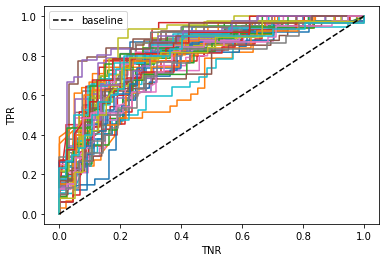

In [42]:
for i in range(len(svm_xaxis)):
    plt.plot(svm_xaxis[i], svm_yaxis[i])

plt.plot([0, 1], [0, 1], "k--", label="baseline")  
plt.ylabel("TPR")
plt.xlabel("TNR")
plt.legend()
plt.show()
    

In [176]:
print(svm_cfm)

[array([[34,  5],
       [17, 21]], dtype=int64), array([[32, 12],
       [17, 16]], dtype=int64), array([[39,  5],
       [13, 20]], dtype=int64), array([[33,  9],
       [18, 17]], dtype=int64), array([[30, 12],
       [11, 24]], dtype=int64), array([[32,  1],
       [24, 20]], dtype=int64), array([[38,  2],
       [19, 18]], dtype=int64), array([[36,  4],
       [14, 23]], dtype=int64), array([[36,  4],
       [17, 20]], dtype=int64), array([[40,  8],
       [12, 17]], dtype=int64), array([[32, 11],
       [11, 23]], dtype=int64), array([[39,  2],
       [15, 21]], dtype=int64), array([[38, 10],
       [14, 15]], dtype=int64), array([[34,  8],
       [15, 20]], dtype=int64), array([[35,  8],
       [15, 19]], dtype=int64), array([[36,  4],
       [20, 17]], dtype=int64), array([[44,  9],
       [12, 12]], dtype=int64), array([[30,  5],
       [19, 23]], dtype=int64), array([[35,  8],
       [10, 24]], dtype=int64), array([[25, 10],
       [20, 22]], dtype=int64), array([[28,  7],
  

### Random Forest

In [169]:
# create Random Forest classifier
def RF_classifier(train_data, train_labels, test_data, test_labels):
    param_grid = {'n_estimators': [200], 'max_features': ['sqrt'], 'max_depth' : [10], 'criterion' :['gini'], 'random_state': [42]}
    clf = RandomForestClassifier()
    rf_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)

    # train model
    rf_clf.fit(train_data, train_labels)

    rf_clf.best_params_
    # print(rf_clf.best_params_)

    # predict model
    pred = (rf_clf.predict(test_data))

    # calculate accuracy
    acc = round(metrics.accuracy_score(test_labels, pred),4)
    cfm = metrics.confusion_matrix(test_labels, pred)
    tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
    tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

    # print("The predicted data is: ", pred)
    # print("The actual data is: ", np.array(val_labels))
    # print(f"The model is {acc*100}% accurate")

    return acc, tpr, tnr, cfm


rf_acc = []
rf_tpr = []
rf_tnr = []
rf_cfm = []

for ii in range(25):
    print('Random State: ', ii+1, end='\r')
    rs = np.linspace(1, 25, 25).astype(np.int)
    x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels', 'hist', 'thresh_val'], axis=1), fft_df.labels, test_size=0.20, random_state=rs[ii]) #'peaks', 'variance', 'SNR', stratify=fft_df.labels
    temp_acc, temp_tpr, temp_tnr, temp_cfm = RF_classifier(x_train, y_train, x_test, y_test)
    rf_acc.append(temp_acc)
    rf_tpr.append(temp_tpr)
    rf_tnr.append(temp_tnr)
    rf_cfm.append(temp_cfm)


print("Random states: ", rs)
# print("Accuracy scores: ", svm_acc)
print("Average accuracy: ", np.mean(rf_acc))
print("Standard deviation: ", np.std(rf_acc))
print("Average TNR: ", np.mean(rf_tnr))
print("Average TPR: ", np.mean(rf_tpr))

Random states:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Average accuracy:  0.7142920000000003
Standard deviation:  0.03367054404074873
Average TNR:  0.7103292358450791
Average TPR:  0.722845720597699


In [170]:
print(rf_cfm)

[array([[30,  9],
       [15, 23]], dtype=int64), array([[35,  9],
       [14, 19]], dtype=int64), array([[36,  8],
       [12, 21]], dtype=int64), array([[29, 13],
       [ 8, 27]], dtype=int64), array([[26, 16],
       [ 4, 31]], dtype=int64), array([[32,  1],
       [24, 20]], dtype=int64), array([[34,  6],
       [17, 20]], dtype=int64), array([[30, 10],
       [ 8, 29]], dtype=int64), array([[32,  8],
       [13, 24]], dtype=int64), array([[36, 12],
       [13, 16]], dtype=int64), array([[36,  7],
       [13, 21]], dtype=int64), array([[29, 12],
       [14, 22]], dtype=int64), array([[38, 10],
       [13, 16]], dtype=int64), array([[32, 10],
       [12, 23]], dtype=int64), array([[30, 13],
       [10, 24]], dtype=int64), array([[32,  8],
       [14, 23]], dtype=int64), array([[38, 15],
       [ 7, 17]], dtype=int64), array([[25, 10],
       [14, 28]], dtype=int64), array([[34,  9],
       [11, 23]], dtype=int64), array([[24, 11],
       [16, 26]], dtype=int64), array([[29,  6],
  

### Naive Bayes Classifier

In [20]:
# Create Naive Bayes Classifier
def NB_classifier(train_data, train_labels, test_data, test_labels):
    
    # train model
    nb_clf = GaussianNB()
    nb_clf.fit(x_train, y_train)

    # predict model
    pred = (nb_clf.predict(x_test))

    # calculate accuracy
    acc = round(metrics.accuracy_score(y_test, pred),4)
    cfm = metrics.confusion_matrix(y_test, pred)
    tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
    tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

    return acc, tpr, tnr, cfm
    
nb_acc = []
nb_tpr = []
nb_tnr = []
nb_cfm = []

for ii in range(25):
    print('Random State: ', ii+1, end='\r')
    rs = np.linspace(1, 25, 25).astype(np.int)
    x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels'], axis=1), fft_df.labels, test_size=0.20, random_state=rs[ii]) #'peaks', 'variance', 'SNR', stratify=fft_df.labels

    temp_acc, temp_tpr, temp_tnr, temp_cfm = NB_classifier(x_train, y_train, x_test, y_test)

    nb_acc.append(temp_acc)
    nb_tpr.append(temp_tpr)
    nb_tnr.append(temp_tnr)
    nb_cfm.append(temp_cfm)


print("Random states: ", rs)
# print("Accuracy scores: ", svm_acc)
print("Average accuracy: ", np.mean(nb_acc))
print("Standard deviation: ", np.std(nb_acc))
print("Average TNR: ", np.mean(nb_tnr))
print("Average TPR: ", np.mean(nb_tpr))

Random states:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Average accuracy:  0.7361080000000001
Standard deviation:  0.060882450147805335
Average TNR:  0.7676506807720309
Average TPR:  0.7190920934841375


In [21]:
print(nb_cfm)

[array([[33,  6],
       [15, 23]], dtype=int64), array([[32, 12],
       [14, 19]], dtype=int64), array([[42,  2],
       [12, 21]], dtype=int64), array([[28, 14],
       [16, 19]], dtype=int64), array([[32, 10],
       [ 7, 28]], dtype=int64), array([[31,  2],
       [19, 25]], dtype=int64), array([[36,  4],
       [10, 27]], dtype=int64), array([[35,  5],
       [11, 26]], dtype=int64), array([[36,  4],
       [13, 24]], dtype=int64), array([[40,  8],
       [11, 18]], dtype=int64), array([[35,  8],
       [14, 20]], dtype=int64), array([[32,  9],
       [11, 25]], dtype=int64), array([[40,  8],
       [11, 18]], dtype=int64), array([[35,  7],
       [15, 20]], dtype=int64), array([[35,  8],
       [11, 23]], dtype=int64), array([[34,  6],
       [19, 18]], dtype=int64), array([[44,  9],
       [12, 12]], dtype=int64), array([[30,  5],
       [24, 18]], dtype=int64), array([[38,  5],
       [10, 24]], dtype=int64), array([[28,  7],
       [13, 29]], dtype=int64), array([[28,  7],
  